<a href="https://colab.research.google.com/github/Glcan22/GSC/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# Gerekli kütüphaneleri yükleme
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np


In [16]:
# Eğitim ve test veri setlerini yükle
train_data = pd.read_csv('/content/0404_01.CSV')  # Eğitim veri seti
test_data = pd.read_csv('/content/0404_02.CSV')    # Test veri seti

# Veri setlerinin ilk birkaç satırını kontrol et
print("Eğitim Veri Seti:")
print(train_data.head())

print("\nTest Veri Seti:")
print(test_data.head())


Eğitim Veri Seti:
      in s   C1 in V   C2 in V   C3 in V   C4 in A
0 -0.00835  0.063867  0.024414  0.024414  0.049766
1 -0.00835  0.015039  0.122070  0.024414  0.030234
2 -0.00835 -0.033789 -0.073242 -0.073242  0.049766
3 -0.00835  0.015039  0.122070  0.024414 -0.047891
4 -0.00835 -0.033789 -0.024414 -0.024414  0.030234

Test Veri Seti:
      in s   C1 in V   C2 in V   C3 in V   C4 in A
0 -0.00835  0.015039 -0.073242 -0.122070 -0.028359
1 -0.00835  0.063867 -0.073242 -0.024414 -0.028359
2 -0.00835 -0.033789 -0.024414 -0.024414 -0.028359
3 -0.00835  0.112695  0.073242 -0.024414  0.010703
4 -0.00835  0.015039  0.024414 -0.073242 -0.047891


In [17]:
# Kilometre başına düşen indeks oranı
km_per_index = 0.000048  # Her indeksin karşılık geldiği kilometre (48 mikrometre)

# Eğitim verisine kilometre bilgisi ekle
train_data['kilometer'] = train_data.index * km_per_index

# Test verisine kilometre bilgisi ekle
test_data['kilometer'] = test_data.index * km_per_index


In [19]:
# Eğitim veri setindeki bilinen anomali aralığı (indeks cinsinden)
anomaly_indices_train = list(range(18785, 19018))  # 18785 ile 19017 arasındaki tüm indeksler

# Veriyi etiketle
train_data['label'] = 0  # Tüm veriyi normal (0) olarak etiketle
train_data.loc[anomaly_indices_train, 'label'] = 1  # Belirtilen aralığı anomali (1) olarak etiketle

# Etiketlerin dağılımını kontrol et
print("Eğitim veri setindeki etiketlerin dağılımı:")
print(train_data['label'].value_counts())


Eğitim veri setindeki etiketlerin dağılımı:
label
0    1399767
1        233
Name: count, dtype: int64


In [8]:
# Random Forest ile modeli eğit
model = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
model.fit(X_train_scaled, y_train)  # Modeli eğitim verisiyle eğit


RandomForestClassifier(class_weight='balanced', random_state=42)

In [9]:
# Test verisindeki özellikler (X_test)
X_test = test_data[['C1 in V', 'C2 in V', 'C3 in V', 'C4 in A']]  # Test özellikleri
X_test_scaled = scaler.transform(X_test)  # Eğitimde kullanılan ölçekle test verisini dönüştür


In [10]:
# Test veri setini yükle
test_data = pd.read_csv('/content/0404_02.CSV')  # Test veri seti adı
test_data.head()  # Test verisinin ilk birkaç satırını kontrol et


,in s,C1 in V,C2 in V,C3 in V,C4 in A
0,-0.00835,0.015039,-0.073242,-0.122070,-0.028359
1,-0.00835,0.063867,-0.073242,-0.024414,-0.028359
2,-0.00835,-0.033789,-0.024414,-0.024414,-0.028359
3,-0.00835,0.112695,0.073242,-0.024414,0.010703
4,-0.00835,0.015039,0.024414,-0.073242,-0.047891


In [11]:
# Test verisinde tahmin yap
y_pred = model.predict(X_test_scaled)  # Test verisinin tahmin edilen etiketleri
test_data['predicted_label'] = y_pred  # Tahmin edilen etiketleri test verisine ekle

# Tespit edilen anomalilerin sayısını kontrol et
print("Test veri setindeki tahmin edilen etiketlerin dağılımı:")
print(test_data['predicted_label'].value_counts())


Test veri setindeki tahmin edilen etiketlerin dağılımı:
predicted_label
0    1399949
1         51
Name: count, dtype: int64


In [12]:
# Eğer test veri setindeki anomaliler biliniyorsa:
# Test verisindeki gerçek anomali etiketleri
test_data['label'] = 0  # Varsayılan olarak tüm veriyi normal kabul et
# Test verisindeki bilinen anomali indekslerini ekle (örneğin, 19017 gibi):
test_data.loc[[19017], 'label'] = 1

# Performansı değerlendirme
print("Performans Raporu:")
print(classification_report(test_data['label'], test_data['predicted_label']))


Performans Raporu:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1399999
           1       0.00      0.00      0.00         1

    accuracy                           1.00   1400000
   macro avg       0.50      0.50      0.50   1400000
weighted avg       1.00      1.00      1.00   1400000



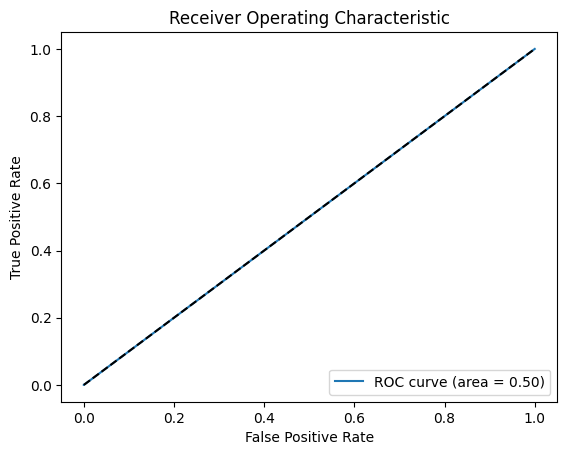

In [13]:
# ROC eğrisini görselleştir
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(test_data['label'], y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [14]:
# Bilinen anomalilerin indeks aralığı
known_anomalies = list(range(18802, 20845))  # 18802 ile 20844 arasındaki tüm indeksler

# Modelin tespit ettiği anomaliler
detected_anomalies = test_data[test_data['predicted_label'] == 1].index.tolist()

# Doğru tespit edilen anomaliler
correctly_detected = [idx for idx in detected_anomalies if idx in known_anomalies]
print(f"Doğru tespit edilen anomaliler: {correctly_detected}")

# Eksik veya yanlış tahmin edilen anomalileri inceleyelim
false_negatives = [idx for idx in known_anomalies if idx not in detected_anomalies]
false_positives = [idx for idx in detected_anomalies if idx not in known_anomalies]
print(f"Kaçırılan anomaliler: {false_negatives}")
print(f"Yanlış pozitifler: {false_positives}")


Doğru tespit edilen anomaliler: []
Kaçırılan anomaliler: [18802, 18803, 18804, 18805, 18806, 18807, 18808, 18809, 18810, 18811, 18812, 18813, 18814, 18815, 18816, 18817, 18818, 18819, 18820, 18821, 18822, 18823, 18824, 18825, 18826, 18827, 18828, 18829, 18830, 18831, 18832, 18833, 18834, 18835, 18836, 18837, 18838, 18839, 18840, 18841, 18842, 18843, 18844, 18845, 18846, 18847, 18848, 18849, 18850, 18851, 18852, 18853, 18854, 18855, 18856, 18857, 18858, 18859, 18860, 18861, 18862, 18863, 18864, 18865, 18866, 18867, 18868, 18869, 18870, 18871, 18872, 18873, 18874, 18875, 18876, 18877, 18878, 18879, 18880, 18881, 18882, 18883, 18884, 18885, 18886, 18887, 18888, 18889, 18890, 18891, 18892, 18893, 18894, 18895, 18896, 18897, 18898, 18899, 18900, 18901, 18902, 18903, 18904, 18905, 18906, 18907, 18908, 18909, 18910, 18911, 18912, 18913, 18914, 18915, 18916, 18917, 18918, 18919, 18920, 18921, 18922, 18923, 18924, 18925, 18926, 18927, 18928, 18929, 18930, 18931, 18932, 18933, 18934, 18935, 1893